In [1]:
#Superresolution autoencoder

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
import os
import glob
import matplotlib.image as mpimg
import psutil
import sys
from copy import deepcopy

2024-08-30 13:43:21.301461: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-30 13:43:21.455481: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-30 13:43:21.516403: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-30 13:43:21.516826: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-30 13:43:21.612928: I tensorflow/core/platform/cpu_feature_gua

In [2]:

# Verificar si TensorFlow reconoce la GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("TensorFlow reconoce las siguientes GPU:")
    for gpu in gpus:
        print(f" - {gpu}")
else:
    print("TensorFlow no reconoce ninguna GPU")

TensorFlow reconoce las siguientes GPU:
 - PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


2024-08-30 13:43:23.792221: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-30 13:43:23.916261: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-30 13:43:23.916300: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [3]:
class two_part_model(tf.keras.Model):
    def __init__(self,block,block2):
        super(two_part_model,self).__init__()
        self.block1=block
        self.block2=block2
        
    def call(self,x):
        encoded=self.block1(x)
        decoded=self.block2(encoded)
        return decoded
        

Carga de datos

In [4]:
def shape_fix(img):
    if img.shape[1]<img.shape[0]:
        image=img[0:img.shape[1],0:img.shape[1]]
    elif img.shape[1]>img.shape[0]:
        image=img[0:img.shape[0],0:img.shape[0]]
    else:
        image=img
    return cv2.resize(image,(512,512))

In [5]:
def total_size(obj, seen=None):
    """Calcula el tamaño total de un objeto en memoria, incluyendo sus elementos."""
    size = sys.getsizeof(obj)
    if seen is None:
        seen = set()
    obj_id = id(obj)
    if obj_id in seen:
        return 0
    seen.add(obj_id)
    if isinstance(obj, dict):
        size += sum([total_size(v, seen) for v in obj.values()])
        size += sum([total_size(k, seen) for k in obj.keys()])
    elif hasattr(obj, '__dict__'):
        size += total_size(obj.__dict__, seen)
    elif hasattr(obj, '__iter__') and not isinstance(obj, (str, bytes, bytearray)):
        size += sum([total_size(i, seen) for i in obj])
    return size

In [6]:
def memory_usage():
    process = psutil.Process()
    return process.memory_info().rss / (1024 * 1024) 

In [7]:
def leer_jpg_de_subcarpetas(carpeta_principal):
    # Obtener todas las rutas de archivos .jpg en todas las subcarpetas
    rutas_jpg = glob.glob(os.path.join(carpeta_principal, '**', '*.jpg'), recursive=True)
    
    return rutas_jpg

def load_files(files_list):
    data=[]
    for file_path in files_list:
        img=cv2.imread(file_path,1)
        img=shape_fix(img)
        data.append(img)

    return data

In [8]:
path='/mnt/d/Repositorios/Deep_Learning/Temas Selectos/P2/AUTOENCODER/Superresolution/Data'
jpg_path=leer_jpg_de_subcarpetas(path)
print(len(jpg_path))
print(f"Uso de memoria: {memory_usage()}" )

12358
Uso de memoria: 705.2578125


In [9]:
for i in range(12350,12357):
    print(jpg_path[i])

/mnt/d/Repositorios/Deep_Learning/Temas Selectos/P2/AUTOENCODER/Superresolution/Data/wildlife/0338.jpg
/mnt/d/Repositorios/Deep_Learning/Temas Selectos/P2/AUTOENCODER/Superresolution/Data/wildlife/0339.jpg
/mnt/d/Repositorios/Deep_Learning/Temas Selectos/P2/AUTOENCODER/Superresolution/Data/wildlife/0340.jpg
/mnt/d/Repositorios/Deep_Learning/Temas Selectos/P2/AUTOENCODER/Superresolution/Data/wildlife/0341.jpg
/mnt/d/Repositorios/Deep_Learning/Temas Selectos/P2/AUTOENCODER/Superresolution/Data/wildlife/0342.jpg
/mnt/d/Repositorios/Deep_Learning/Temas Selectos/P2/AUTOENCODER/Superresolution/Data/wildlife/0343.jpg
/mnt/d/Repositorios/Deep_Learning/Temas Selectos/P2/AUTOENCODER/Superresolution/Data/wildlife/0344.jpg


In [10]:
data=[]
print(len(jpg_path))
batch_size=len(jpg_path)//37
step=0
for i in range(37):
    try:
        data+=load_files(jpg_path[step:batch_size+step])
        step+=batch_size
        print(f"{i+1} bloques leidos {memory_usage()} MB")
        if memory_usage()>14000:
            break
    except MemoryError:
         print(f"Fallo en el bloque {i + 1} por falta de memoria.")
         break  # Sal del bucle si ocurre un error de memoria.

12358
1 bloques leidos 976.2578125 MB
2 bloques leidos 1226.89453125 MB
3 bloques leidos 1477.20703125 MB
4 bloques leidos 1727.76953125 MB
5 bloques leidos 1978.33984375 MB
6 bloques leidos 2228.42578125 MB
7 bloques leidos 2478.86328125 MB
8 bloques leidos 2728.66015625 MB
9 bloques leidos 2980.6796875 MB
10 bloques leidos 3230.4453125 MB
11 bloques leidos 3477.98046875 MB
12 bloques leidos 3732.55078125 MB
13 bloques leidos 3983.0234375 MB
14 bloques leidos 4233.65234375 MB
15 bloques leidos 4482.7109375 MB
16 bloques leidos 4734.63671875 MB
17 bloques leidos 4984.3671875 MB
18 bloques leidos 5235.11328125 MB
19 bloques leidos 5484.77734375 MB
20 bloques leidos 5735.31640625 MB
21 bloques leidos 5986.96875 MB
22 bloques leidos 6238.22265625 MB
23 bloques leidos 6487.046875 MB
24 bloques leidos 6737.55078125 MB
25 bloques leidos 6988.37109375 MB
26 bloques leidos 7239.375 MB
27 bloques leidos 7491.234375 MB
28 bloques leidos 7741.28125 MB
29 bloques leidos 7990.5390625 MB
30 bloques 

Exploracion de los datos

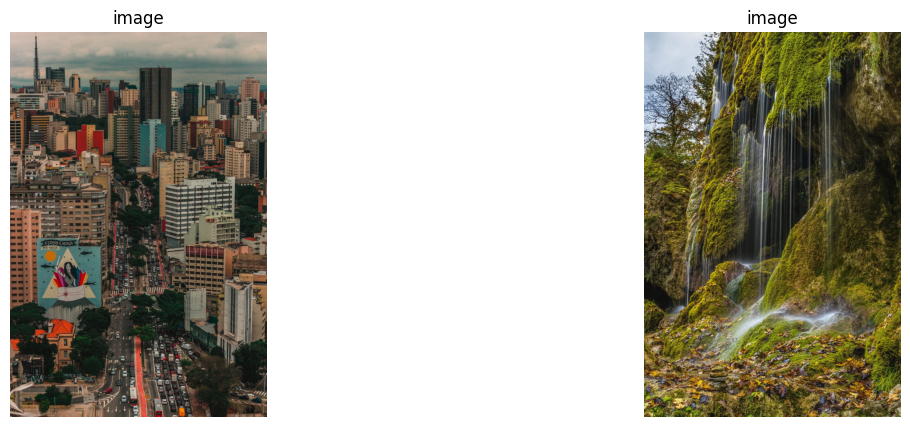

In [11]:
def show_images(image_paths, titles):
    num_images = len(image_paths)
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))  # Ajustar el tamaño de la figura según el número de imágenes
    for i in range(num_images):
        # Cargar la imagen y convertirla a RGB
        image = cv2.cvtColor(cv2.imread(image_paths[i]), cv2.COLOR_BGR2RGB)
        # Mostrar la imagen en la subtrama correspondiente
        axes[i].imshow(image)
        axes[i].axis('off')  # Desactivar los ejes
        axes[i].set_title(titles[i])  # Establecer el título de la subtrama
    plt.show()
    
def show_loaded_images(images, titles):
    num_images = len(images)
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))  # Ajustar el tamaño de la figura según el número de imágenes
    
    for i in range(num_images):
        # Convertir la imagen de BGR a RGB
        image_rgb = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)
        
        # Mostrar la imagen en la subtrama correspondiente
        axes[i].imshow(image_rgb)
        axes[i].axis('off')  # Desactivar los ejes
        axes[i].set_title(titles[i])  # Establecer el título de la subtrama
    
    plt.show()
    
image_paths = [jpg_path[88], jpg_path[7600]]
titles = ['image', 'image']
show_images(image_paths, titles)

In [12]:
print(len(data))
print(f"Tamano en memoria {total_size(data)} bytes")

12358
Tamano en memoria 9720606569 bytes


Normalizado de datos


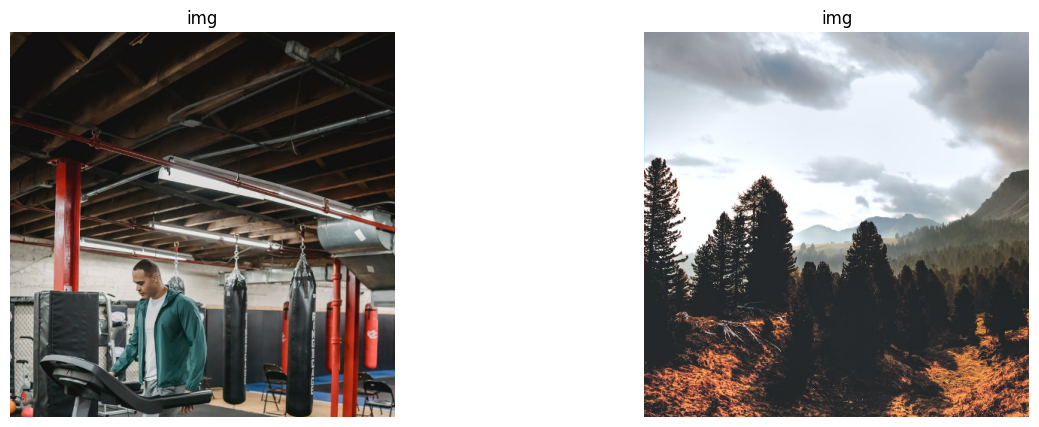

In [13]:
show_loaded_images((data[1400],data[7250]),['img','img'])

In [20]:
import random 
def undersampled_image(images):
   
    if isinstance(images,np.ndarray):
        aux=deepcopy(images)
        rd=random.randint(128,256)
        aux=cv2.resize(aux,(rd,rd))
        return cv2.resize(aux,(512,512))
    """output=[]
    for image in images:
        aux=deepcopy(image)
        aux=cv2.resize(aux,(256,256))
        output.append( cv2.resize(aux,(512,512)))
    return output    """

In [21]:
X_data=[]
for image in data:
    X_data.append(undersampled_image(image))
y_data=data


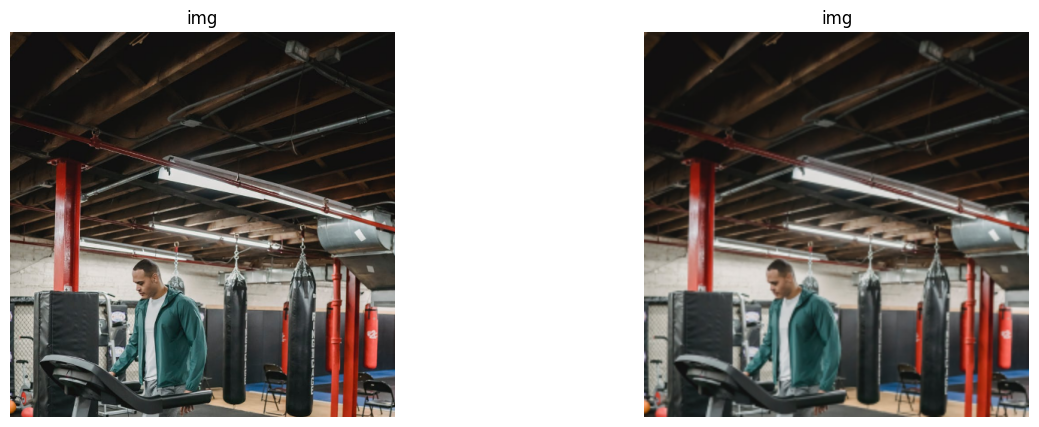

In [ ]:
show_loaded_images((y_data[1400],X_data[1400]),['img','img'])

* Modelo 

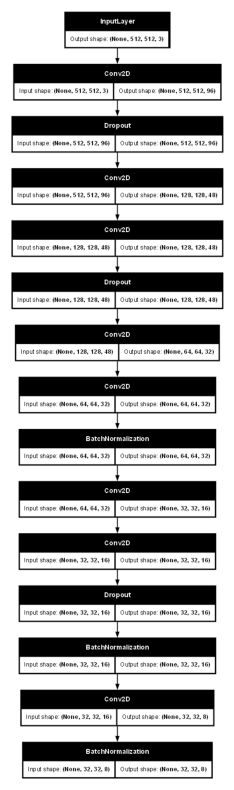

In [22]:
#Encoder
input_layer=tf.keras.layers.Input((512,512,3))

#X=tf.keras.layers.Conv2D(filters=64,kernel_size=(3,3),activation='relu',padding='same',strides=2)

X=tf.keras.layers.Conv2D(filters=96,kernel_size=(9,9),activation='relu',padding='same')(input_layer)
X=tf.keras.layers.Dropout(.2)(X)
X=tf.keras.layers.Conv2D(filters=48,kernel_size=(9,9),activation='relu',padding='same',strides=4)(X)
X=tf.keras.layers.Conv2D(filters=48,kernel_size=(5,5),activation='relu',padding='same')(X)
X=tf.keras.layers.Dropout(.3)(X)
#X=tf.keras.layers.MaxPool2D(pool_size=(2,2),padding='same')(X)
X=tf.keras.layers.Conv2D(filters=32,kernel_size=(7,7),activation='relu',padding='same',strides=2)(X)
X=tf.keras.layers.Conv2D(filters=32,kernel_size=(5,5),activation='relu',padding='same')(X)
X=tf.keras.layers.BatchNormalization()(X)

#X=tf.keras.layers.MaxPool2D(pool_size=(2,2),padding='same')(X)
X=tf.keras.layers.Conv2D(filters=16,kernel_size=(7,7),activation='relu',padding='same',strides=2)(X)
X=tf.keras.layers.Conv2D(filters=16,kernel_size=(5,5),activation='relu',padding='same')(X)
X=tf.keras.layers.Dropout(.3)(X)
X=tf.keras.layers.BatchNormalization()(X)


#X=tf.keras.layers.MaxPool2D(pool_size=(2,2),padding='same')(X)
X=tf.keras.layers.Conv2D(filters=8,kernel_size=(5,5),activation='relu',padding='same')(X)
X=tf.keras.layers.BatchNormalization()(X)

encoder=tf.keras.Model(inputs=input_layer, outputs=X)

tf.keras.utils.plot_model(encoder,to_file='encoder.png', show_shapes=True, dpi=64,show_dtype=False)
#Latent_size=(16,16,48)
img = mpimg.imread('/mnt/d/Repositorios/Deep_Learning/Temas Selectos/P2/AUTOENCODER/Superresolution/encoder.png')
plt.figure(figsize=(10, 10))
imgplot = plt.imshow(img)
plt.axis('off')
plt.show()

In [23]:
encoder.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 512, 512, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 512, 512, 96)   │        23,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512, 512, 96)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 48)   │       373,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 128, 128, 48)   │        57,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128, 128, 48)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 32)     │        75,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 32)     │        25,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 16)     │        25,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 16)     │         6,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 32, 32, 8)      │         3,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 8)      │            32 │
│ (BatchNormalization)            │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 590,248 (2.25 MB)

 Trainable params: 590,136 (2.25 MB)

 Non-trainable params: 112 (448.00 B)

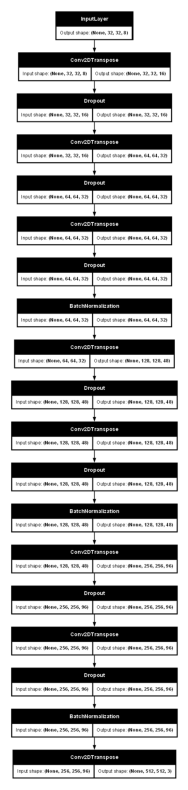

In [24]:
input_layer2=tf.keras.layers.Input(shape=encoder.output_shape[1:])


Y=tf.keras.layers.Conv2DTranspose(16,kernel_size=(7,7),activation='relu',padding='same')(input_layer2)
Y=tf.keras.layers.Dropout(.2)(Y)
Y=tf.keras.layers.Conv2DTranspose(32,kernel_size=(7,7),activation='relu',padding='same',strides=2)(Y)
Y=tf.keras.layers.Dropout(.2)(Y)
Y=tf.keras.layers.Conv2DTranspose(32,kernel_size=(5,5),activation='relu',padding='same')(Y)
Y=tf.keras.layers.Dropout(.2)(Y)
Y=tf.keras.layers.BatchNormalization()(Y)
Y=tf.keras.layers.Conv2DTranspose(48,kernel_size=(7,7),activation='relu',padding='same',strides=2)(Y)
Y=tf.keras.layers.Dropout(.2)(Y)
Y=tf.keras.layers.Conv2DTranspose(48,kernel_size=(5,5),activation='relu',padding='same')(Y)
Y=tf.keras.layers.Dropout(.2)(Y)
Y=tf.keras.layers.BatchNormalization()(Y)
Y=tf.keras.layers.Conv2DTranspose(96,kernel_size=(7,7),activation='relu',padding='same',strides=2)(Y)
Y=tf.keras.layers.Dropout(.2)(Y)
Y=tf.keras.layers.Conv2DTranspose(96,kernel_size=(5,5),activation='relu',padding='same')(Y)
Y=tf.keras.layers.Dropout(.2)(Y)
Y=tf.keras.layers.BatchNormalization()(Y)
Y=tf.keras.layers.Conv2DTranspose(3,kernel_size=(7,7),activation='relu',padding='same',strides=2)(Y)





decoder=tf.keras.Model(inputs=input_layer2,outputs=Y)


tf.keras.utils.plot_model(decoder,to_file='decoder.png', show_shapes=True, dpi=64,show_dtype=False)
Latent_size=(2,2,48)
img = mpimg.imread('/mnt/d/Repositorios/Deep_Learning/Temas Selectos/P2/AUTOENCODER/Superresolution/decoder.png')
plt.figure(figsize=(10, 10))
imgplot = plt.imshow(img)
plt.axis('off')
plt.show()

In [25]:
decoder.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 32, 32, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 32, 32, 16)     │         6,288 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 64, 64, 32)     │        25,120 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 64, 64, 32)     │        25,632 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 128, 128, 48)   │        75,312 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128, 128, 48)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 128, 128, 48)   │        57,648 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128, 128, 48)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128, 128, 48)   │           192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 256, 256, 96)   │       225,888 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256, 256, 96)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_6              │ (None, 256, 256, 96)   │       230,496 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 256, 256, 96)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 256, 256, 96)   │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_7              │ (None, 512, 512, 3)    │        14,115 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 661,203 (2.52 MB)

 Trainable params: 660,851 (2.52 MB)

 Non-trainable params: 352 (1.38 KB)

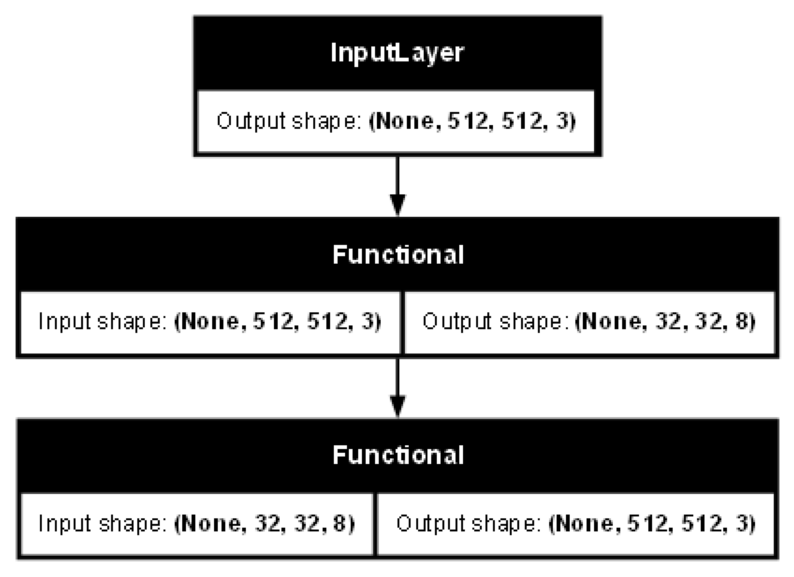

In [26]:
encoded=encoder(input_layer)
decoded=decoder(encoded)
autoencoder=tf.keras.models.Model(input_layer,decoded)
tf.keras.utils.plot_model(autoencoder,to_file='autoencoder.png', show_shapes=True, dpi=64,show_dtype=False)
#Latent_size=(16,16,48)
img = mpimg.imread('/mnt/d/Repositorios/Deep_Learning/Temas Selectos/P2/AUTOENCODER/Superresolution/autoencoder.png')
plt.figure(figsize=(10, 10))
imgplot = plt.imshow(img)
plt.axis('off')
plt.show()

In [27]:
autoencoder.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 512, 512, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_1 (Functional)       │ (None, 32, 32, 8)      │       590,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_3 (Functional)       │ (None, 512, 512, 3)    │       661,203 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,251,451 (4.77 MB)

 Trainable params: 1,250,987 (4.77 MB)

 Non-trainable params: 464 (1.81 KB)

In [28]:
Superresolution=two_part_model(X_data,y_data)
Superresolution.compile(optimizer='adam',loss='mse')

* Conversion de datos


In [29]:
X_train,X_test,y_train,y_test=train_test_split(X_data,y_data,test_size=.2,random_state=42)
X_train,X_valid,y_train,y_valid=train_test_split(X_train,y_train,test_size=.1,random_state=21)


8897
2472
989


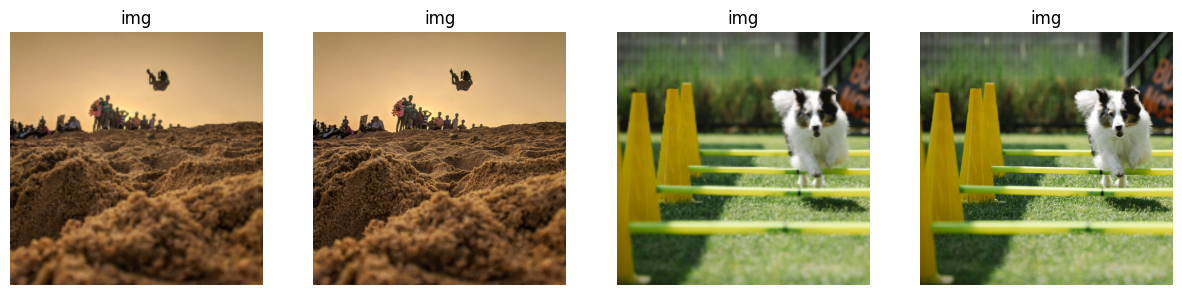

In [31]:
print(len(X_train))
print(len(X_test))
print(len(X_valid))
show_loaded_images((X_train[0],y_train[0],X_test[1200],y_test[1200]),['img','img','img','img'])

In [32]:
history=Superresolution.fit(X_train,y_train,
                            epochs=100,
                            shuffle=True,
                            validation_data=(X_valid,y_valid),
                            batch_size=100)

In [ ]:
test_loss, test_acc = Superresolution.evaluate(X_test,y_test)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

In [ ]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)